In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
N = 10000
bins = [0, 1, 2, 3, 4, np.inf]
truth_data = np.random.exponential(scale=1.0, size=N)
truth_hist, _ = np.histogram(truth_data, bins=bins)
resolution = np.random.normal(loc=1., scale=0.3, size=N)
efficiency = np.random.uniform(size=N) > 1 - sigmoid(truth_data / 4)
observed_data = (resolution * truth_data)[efficiency]
observed_hist, _ = np.histogram(observed_data, bins=bins)
migrations, _, _ = np.histogram2d(observed_data, truth_data[efficiency], bins=bins)
response = migrations / truth_hist

In [4]:
# test closure
np.testing.assert_almost_equal(np.dot(response, truth_hist), observed_hist)

In [5]:
model = pm.Model()

with model:
    params = pm.DiscreteUniform(
        "params", 
        lower=truth_hist // 10, 
        upper=truth_hist * 10,
    )
    likelihood = pm.Poisson(
        "likelihood", mu=pm.math.dot(response, params),
        observed=observed_hist,
    )
    trace = pm.sample(draws=50000, tune=10000)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 10 seconds.


In [6]:
truth_hist

array([6281, 2353,  855,  304,  207])

In [7]:
trace.posterior.params.mean(axis=1).to_numpy()

array([[6281.28624, 2362.3562 ,  837.17448,  328.59854,  198.07114],
       [6282.60016, 2361.91742,  837.34302,  330.32006,  196.46126],
       [6279.69624, 2363.34016,  844.58984,  318.74182,  202.199  ],
       [6281.11968, 2359.39696,  844.88478,  321.17334,  200.64194]])

In [8]:
trace.posterior.params.std(axis=1).to_numpy()

array([[125.31340322, 128.16944285, 154.99859198, 154.86302299,
         74.46108782],
       [125.56087037, 126.54126157, 152.8367584 , 154.58905415,
         74.52745091],
       [122.86655399, 128.94400355, 154.7236498 , 154.17806317,
         74.05810178],
       [125.40576253, 127.14860118, 155.336698  , 156.4927816 ,
         75.07951074]])

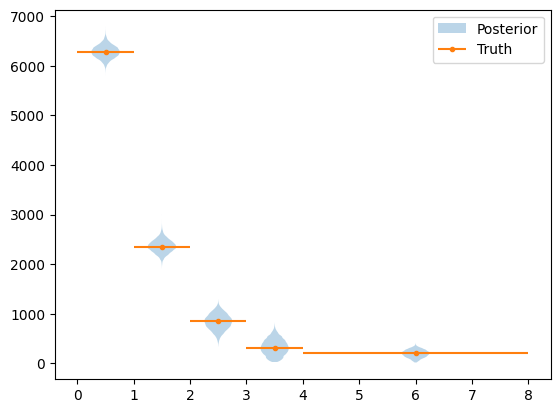

In [9]:
positions = [0.5, 1.5, 2.5, 3.5, 6]
xerr = [0.5, 0.5, 0.5, 0.5, 2]
vp = plt.violinplot(
    trace.posterior.params[0],
    positions=positions,
    showextrema=False,
)
eb = plt.errorbar(
    x=positions,
    y=truth_hist,
    xerr=xerr,
    fmt=".",
)
plt.legend([vp["bodies"][0], eb.lines], ["Posterior", "Truth"])

# Unseen distribution with same resolution/efficiency

In [10]:
new_truth_data = np.random.exponential(scale=2.0, size=N)
new_truth_hist, _ = np.histogram(new_truth_data, bins=bins)
new_efficiency = np.random.uniform(size=N) > 1 - sigmoid(new_truth_data / 4)
new_observed_data = (resolution * new_truth_data)[new_efficiency]
new_observed_hist, _ = np.histogram(new_observed_data, bins=bins)

In [11]:
np.dot(response, new_truth_hist)

array([2270.21325429, 1386.99396787,  872.66523694,  564.25773938,
       1038.02913806])

In [12]:
new_observed_hist

array([2263, 1363,  896,  548, 1080])

In [13]:
np.histogram(truth_data[efficiency], bins=bins)[0] / truth_hist

array([0.52412036, 0.58988525, 0.64912281, 0.74013158, 0.79710145])

In [14]:
np.histogram(new_truth_data[new_efficiency], bins=bins)[0] / new_truth_hist

array([0.53980288, 0.58238517, 0.64594972, 0.6970339 , 0.8137558 ])

In [15]:
model = pm.Model()

with model:
    params = pm.DiscreteUniform(
        "params", 
        lower=truth_hist // 10, 
        upper=truth_hist * 10,
    )
    likelihood = pm.Poisson(
        "likelihood", mu=pm.math.dot(response, params),
        observed=new_observed_hist,
    )
    new_trace = pm.sample(draws=50000, tune=10000)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 10 seconds.


In [16]:
new_truth_hist

array([3957, 2373, 1432,  944, 1294])

In [17]:
new_trace.posterior.params.mean(axis=1)

<xarray.DataArray 'params' (chain: 4, params_dim_0: 5)> Size: 160B
array([[3981.2329 , 2205.7553 , 1715.00998,  595.98228, 1522.40756],
       [3976.69094, 2224.1412 , 1677.75188,  645.01822, 1496.95798],
       [3978.36432, 2216.80916, 1695.24878,  619.04618, 1511.95456],
       [3979.17312, 2213.09912, 1701.36396,  615.85938, 1511.50898]])
Coordinates:
  * chain         (chain) int64 32B 0 1 2 3
  * params_dim_0  (params_dim_0) int64 40B 0 1 2 3 4

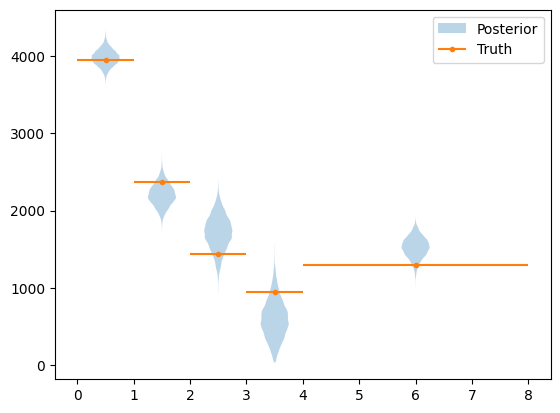

In [18]:
positions = [0.5, 1.5, 2.5, 3.5, 6]
xerr = [0.5, 0.5, 0.5, 0.5, 2]
vp = plt.violinplot(
    new_trace.posterior.params[0],
    positions=positions,
    showextrema=False,
)
eb = plt.errorbar(
    x=positions,
    y=new_truth_hist,
    xerr=xerr,
    fmt=".",
)
plt.legend([vp["bodies"][0], eb.lines], ["Posterior", "Truth"])